# DeepTesla@Celerative (Udacity simulator dataset) (in English)
### Inspiration
* http://selfdrivingcars.mit.edu/deeptesla/
* https://github.com/naokishibuya/car-behavioral-cloning

### Objective
* Design and implement a CNN to predict the steering angle from the pictures taken from vehicle cameras.
* Use the Udacity Self-Driving Car Simulator to test the CNN.

### Resources
* Keras documentation: https://keras.io/
* OpenCV documentation: http://opencv.org/
* Introduction to Udacity Self-Driving Car Simulator: https://medium.com/towards-data-science/introduction-to-udacity-self-driving-car-simulator-4d78198d301d

### Useful links
* Augmentation based DNN: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9

## Utility definitions and functions (utils.py)

The script to provide useful functionalities (i.e. image preprocessing and augumentation)

utils.py is originally from https://github.com/naokishibuya/car-behavioral-cloning

In [3]:
import numpy as np
import matplotlib.image as mpimg
import cv2, os

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 128, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle

def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

## CNN Models

Two models were designed and empirically tuned-up.

Both models feature a first lambda layer that normalize the input range from [0; 255] to [-1; 1]

Also both models will be trained to output a normalized [-1; 1] angle.

* Flat model:
    "Flat and dense" model. Features only few layers compared to the current CNNs commonly used.
* Nvidia-style model:
    Deep NN model. Based on the models from: 
    * https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf (Chapter 5 - Fig. 4)
    * https://web.wpi.edu/Pubs/E-project/Available/E-project-032317-223611/unrestricted/Reportv4.pdf (Chapter 4 - Fig. 16)

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

"""
Flat model
"""
def build_flat_model():
    model = Sequential() # 64x128 x 3
    model.add(Lambda(lambda x: x/127.5 - 1,
              input_shape = INPUT_SHAPE))
    
    model.add(Conv2D(8, (3, 3), padding = 'same',
                     activation = 'elu')) # 64x128 x 8

    model.add(Conv2D(16, (3, 3), padding = 'same',
                     activation = 'elu')) # 64x128 x 16
    model.add(MaxPooling2D(pool_size = (2, 2))) # 32x64 x 16
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(128, activation = 'elu'))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(loss = 'mean_squared_error',
                  optimizer = Adam(lr = 1.0e-4))
#                  optimizer = 'adadelta')
    
    return model

"""
Nvidia-style model
"""
def build_nv_model():
    model = Sequential() # 64x128x3
    model.add(Lambda(lambda x: x/127.5 - 1,
              input_shape = INPUT_SHAPE))
    
    model.add(Conv2D(24, (5, 5), activation = 'elu',
                     padding = 'same')) # 64x128 x 24
    model.add(MaxPooling2D(pool_size = (2, 2))) # 32x64 x 24

    model.add(Conv2D(36, (5, 5), activation = 'elu')) # 28x60 x 36
    model.add(MaxPooling2D(pool_size = (2, 2))) # 14x30 x 36

    model.add(Conv2D(48, (5, 5), activation = 'elu')) # 10x26 x 48
    model.add(MaxPooling2D(pool_size = (2, 2))) # 5x13 x 48

    model.add(Conv2D(64, (3, 3), activation = 'elu')) # 3x11 x 64

    model.add(Conv2D(64, (3, 3), activation = 'elu')) # 1x9 x 64
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.2))

    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation = 'elu'))

    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mean_squared_error',
                  optimizer = Adam(lr = 1.0e-4))
#                  optimizer = 'adadelta')

    return model

## Reading data generated by the simulator

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_data(data_dir, test_size = .2):
    """
    Load training data and split it into training and validation set
    """
    data_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), header = None,
                          names = ['center', 'left', 'right', 'steering', 'e', 'f', 'speed'],
                          dtype = {'center': str,
                                   'left': str,
                                   'right': str,
                                   'steering': np.float32 })
    
    X = data_df[['center', 'left', 'right']].values
    y = data_df['steering'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

## CNN Training

Already trained models can be downloaded from:
* Nvidia-style models: https://drive.google.com/file/d/0B8PJB_fXB-_FYS1oOWotQVBpd2c/view?usp=sharing

In [6]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Hyper-parameters
epochs = 5
batch_size = 32

data_dir = "/mnt/j/Datasets/udacity-sim/"

# Data!
X_train, X_valid, y_train, y_valid = load_data(data_dir)

#model = build_flat_model()
model = load_model('uda-flat-model-104.h5')

checkpoint = ModelCheckpoint('uda-flat-model-2{epoch:02d}.h5',
                             monitor = 'val_loss',
                             verbose = 1,
#                             save_best_only = True,
                             mode = 'auto')

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.,
                          patience = 4,
                          verbose = 0)

model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = 500,
                    epochs = epochs,
                    validation_data = batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    validation_steps = len(X_valid) // batch_size,
                    callbacks = [checkpoint],
                    verbose = 2)


Epoch 1/5


/home/jameru/Projects/pps/env/lib/python3.5/site-packages/ipykernel_launcher.py:90: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 64


Epoch 00000: saving model to uda-flat-model-200.h5
274s - loss: 0.0243 - val_loss: 0.0155
Epoch 2/5
Epoch 00001: saving model to uda-flat-model-201.h5
269s - loss: 0.0240 - val_loss: 0.0134
Epoch 3/5
Epoch 00002: saving model to uda-flat-model-202.h5
268s - loss: 0.0231 - val_loss: 0.0164
Epoch 4/5
Epoch 00003: saving model to uda-flat-model-203.h5
269s - loss: 0.0235 - val_loss: 0.0150
Epoch 5/5
Epoch 00004: saving model to uda-flat-model-204.h5
272s - loss: 0.0223 - val_loss: 0.0129


## Observations

* uda-nv-model-104.h5 takes an alternative route at the first track, then it succesfully returns to the main track.
* uda-nv-model-204.h5 already completes the main track.
* At uda-nv-model-304.h5, loss and val_loss begin to converge.

## Testing in the DeepTesla dataset

(5400,)
(5400, 1)


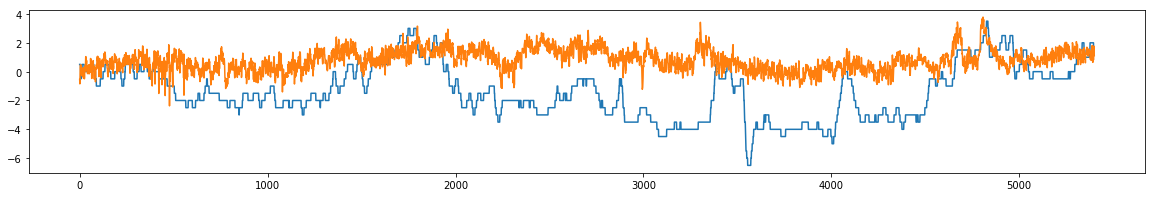

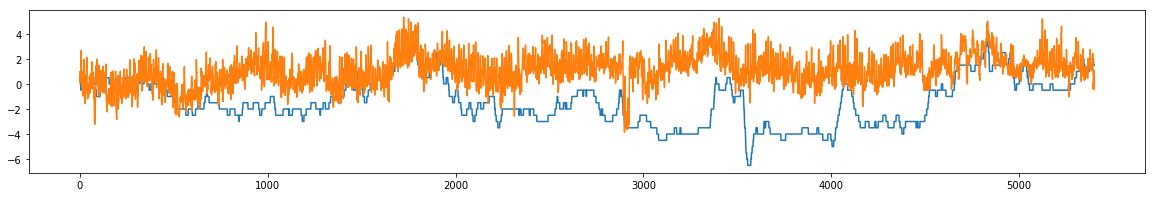

In [9]:
from __future__ import print_function

from PIL import Image
import matplotlib.pyplot as plt
import glob

#save_dir = os.path.join(os.getcwd(), 'saved_models')
model1_name = 'uda-flat-model-204.h5'
model2_name = 'uda-nv-model-404.h5'
#model1_path = os.path.join(save_dir, model1_name)

model1 = load_model(model1_name)
model2 = load_model(model2_name)

x_test = []
filelist = glob.glob("/mnt/j/Datasets/deeptesla/validation/*.jpg")
for fname in filelist:
     x_test.append(rgb2yuv(np.array(Image.open(fname))))
x_test = np.array(x_test, dtype = 'float32')

y_test = np.loadtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')
print(y_test.shape)

plt.rcParams["figure.figsize"] = (20, 3)

arr1 = model1.predict(x_test) * 25
arr2 = model2.predict(x_test) * 25
print(arr1.shape)

plt.plot(y_test)
plt.plot(arr1)
plt.show()

plt.figure()
plt.plot(y_test)
plt.plot(arr2)
plt.show()